# Section 3: 2010-2022 pDB port capacity evolution (paper fig1)

In this notebook with retrieve the global port capacity evolution reported in PeeringDB

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import datetime

import matplotlib.dates as mdates

from scipy.optimize import curve_fit

from tqdm import tqdm

In [2]:
DATE_START = datetime.date(2010,1,1)
DATE_STOP = datetime.date(2021,12,31)

Caida snapshots can either be missing or corrupted  
list of Caida pDB snapshots : removing corrupted files

In [3]:
snapshot_list_file = open("caida_pdbs/download/files_list.txt", "r")
snapshots = []
for line in snapshot_list_file:
    if line.split('_')[0] == "peeringdb":
        snapshot = line.rstrip()
#         print(snapshot.split("_"))
#         print(snapshot.split("_")[-3], snapshot.split("_")[-2], snapshot.split("_")[-1].rstrip(".json").rstrip(".sqlite"))
        
        date = datetime.date(int(snapshot.split("_")[-3]), int(snapshot.split("_")[-2]) ,  int(snapshot.split("_")[-1].rstrip(".json").rstrip(".sqlite")))
        if DATE_START <= date and date <= DATE_STOP:
            snapshots.append(snapshot)
        
corrupted = ["2013_08_09",
             "2015_04_05",
             "2015_07_23",
             "2015_11_10",
             "2016_05_27",
             "2016_05_28",
             "2016_05_29",
             "2016_05_30",
            "2019_08_28",
            "2019_08_29",
            "2019_08_30",
            "2019_08_31",
            "2019_09_01",
            "2019_09_02",
            "2019_09_03",
            "2019_09_04",
            "2019_09_05",
            "2019_09_06"]

print(len(snapshots), "snapshots reported by Caida")
snapshots = [element for element in snapshots if element.split("dump_")[1].rstrip(".sqlite").rstrip(".json") not in corrupted]
print(len(snapshots), "snapshots not corrupded")

3970 snapshots reported by Caida
3952 snapshots not corrupded


## Quantifying missing snapshots

In [4]:
missing_dates = []
for i in range(len(snapshots)-1):
    date1 = datetime.date(int(snapshots[i].split("_")[-3]), int(snapshots[i].split("_")[-2]) ,  int(snapshots[i].split("_")[-1].rstrip(".json").rstrip(".sqlite")))
    date2 = datetime.date(int(snapshots[i+1].split("_")[-3]), int(snapshots[i+1].split("_")[-2]) ,  int(snapshots[i+1].split("_")[-1].rstrip(".json").rstrip(".sqlite")))
    
    delta = (date2-date1).days
    
    if delta > 1:
        for i in range(1,delta):
            missing_dates.append(date1 + datetime.timedelta(days=i))
missing_dates

[datetime.date(2010, 10, 13),
 datetime.date(2010, 10, 14),
 datetime.date(2010, 10, 15),
 datetime.date(2010, 10, 16),
 datetime.date(2010, 10, 17),
 datetime.date(2010, 10, 18),
 datetime.date(2010, 10, 19),
 datetime.date(2010, 10, 20),
 datetime.date(2010, 10, 21),
 datetime.date(2010, 10, 22),
 datetime.date(2010, 10, 23),
 datetime.date(2010, 10, 24),
 datetime.date(2010, 10, 25),
 datetime.date(2010, 10, 26),
 datetime.date(2010, 10, 27),
 datetime.date(2010, 10, 28),
 datetime.date(2010, 10, 29),
 datetime.date(2010, 10, 30),
 datetime.date(2010, 10, 31),
 datetime.date(2010, 11, 22),
 datetime.date(2010, 11, 23),
 datetime.date(2010, 11, 24),
 datetime.date(2010, 11, 25),
 datetime.date(2010, 11, 26),
 datetime.date(2010, 11, 27),
 datetime.date(2010, 11, 28),
 datetime.date(2010, 11, 29),
 datetime.date(2010, 11, 30),
 datetime.date(2011, 1, 17),
 datetime.date(2011, 1, 18),
 datetime.date(2011, 1, 19),
 datetime.date(2011, 1, 20),
 datetime.date(2011, 1, 21),
 datetime.date(

In [5]:
def get_largest_consecutive_interval(days):
    """
    Store the longest interval and the current consecutive interval as we iterate through a list.
    Thanks to Michilus https://stackoverflow.com/a/63623400.
    """
    longest_interval_index = current_interval_index =  0
    longest_interval_length = current_interval_length = 1

    # using zip here to reduce the number of indexing operations
    # this will turn the days list into [(2020-01-1, 2020-01-02), (2020-01-02, 2020-01-03), ...]
    # use enumerate to get the index of the current day
    for i, (previous_day, current_day) in enumerate(zip(days, days[1:]), start=1):
        if current_day - previous_day == datetime.timedelta(days=+1):
            # we've found a consecutive day! increase the interval length
            current_interval_length += 1
        else:
            # nope, not a consecutive day! start from this day and start
            # counting from 1
            current_interval_index = i
            current_interval_length = 1
        if current_interval_length > longest_interval_length:
            # we broke the record! record it as the longest interval
            longest_interval_index = current_interval_index
            longest_interval_length = current_interval_length
    
    return longest_interval_index, days[longest_interval_index:longest_interval_index + longest_interval_length]
#     print("Longest interval index:", longest_interval_index)
#     print("Longest interval: ", days[longest_interval_index:longest_interval_index + longest_interval_length])

In [6]:
print(len(get_largest_consecutive_interval(missing_dates)[1]), "days for the longest missing interval")

77 days for the longest missing interval


In [7]:
print(100*len(missing_dates)/(DATE_STOP-DATE_START).days , "% of missing days over the whole interval")

5.066179826563213 % of missing days over the whole interval


## Getting port_capacity

If we want `port_capacity` evolution to be more localized

In [ ]:
regions = ["Africa", "South America", "Australia", "North America", "Asia Pacific", "Europe"]

countries = ["BR", "ES", "IT", "IN", "HK", "US", "SG", "PL", "RU", "FR", "GB", "DE", "NL"]

ASes = ["Netflix", "Microsoft", "Hurricane E.", "Facebook", "Akamai", "Apple Inc.", "Google LLC"]
ASNs = [2906, 8075, 6939, 32934, 20940, 714, 15169] #what I took in the paper
#Apple ASN 714 is not in pDB for early snapshots
# ASes = ["Netflix", "Microsoft", "Hurricane E.", "Facebook", "Akamai", "Google LLC"]
# ASNs = [2906, 8075, 6939, 32934, 20940, 15169]

Retrieving `port_capacity`

In [9]:
dates = []
records = pd.DataFrame()

dates = [datetime.date(int(snapshot.split("_")[-3]), int(snapshot.split("_")[-2]) ,  int(snapshot.split("_")[-1].rstrip(".json").rstrip(".sqlite"))) for snapshot in snapshots]
for i in tqdm(range(len(snapshots))):
    to_study = {}
#     to_study["date"] = dates[i]
    pickle_filename = snapshots[i].rstrip("json").rstrip("sqlite")+"pickle"

    pickle_in = open("caida_pdbs/processed/net/"+pickle_filename,"rb")
    net = pickle.load(pickle_in)
    net = net.loc[net["port_capacity"]>0]
    pickle_in.close()

    pickle_in = open("caida_pdbs/processed/ix/"+pickle_filename,"rb")
    ix = pickle.load(pickle_in)
    ix = ix.loc[ix["port_capacity"]>0]
    pickle_in.close()

    pickle_in = open("caida_pdbs/processed/nodes/"+pickle_filename,"rb")
    nodes = pickle.load(pickle_in)
    nodes = nodes.loc[nodes["port_capacity"]>0]
    pickle_in.close()

    to_study["nnets"] = len(net)
    to_study["nixs"] = len(ix)
    to_study["nnodes"] = len(nodes)

    to_study["global_portcapa"] = np.sum(ix.port_capacity)

    ## what we measure for the paper
    for key in countries:
        to_study[key+"_portcapa"] = np.sum(ix.loc[ix.country==key].port_capacity)
    for key in regions:
        to_study[key+"_portcapa"] = np.sum(ix.loc[ix.region_continent==key].port_capacity)
    for j in range(len(ASes)):
        if ASNs[j] not in net.index:
            to_study[ASes[j]+"_portcapa"] = np.nan
        else:
            to_study[ASes[j]+"_portcapa"] = net.loc[ASNs[j], "port_capacity"]
            
    ## I take a look at the top ASes for snapshots having outliers. Let's see who badly reported its port size.
    ASes_suspect = net[["port_capacity", "name"]].sort_values(by="port_capacity", ascending=False).head(10)
#     print(dates[i], ASes_suspect)
    if dates[i] == datetime.date(2017,10,17):
        ASes_suspect.to_csv("top_pc_2017.csv")
    if dates[i] == datetime.date(2015,1,1):
        ASes_suspect.to_csv("top_pc_2015.csv")
        

    records = records.append(pd.DataFrame(data=to_study, index = pd.DatetimeIndex([dates[i]])))

records.rename_axis("date", inplace=True)
records.to_csv("caida_pdbs/processed/records.csv")

100%|███████████████████████████████████████| 3952/3952 [07:59<00:00,  8.24it/s]


[3.93024869e+05 3.61119615e+02] [528687.1278018     671.89093605]


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


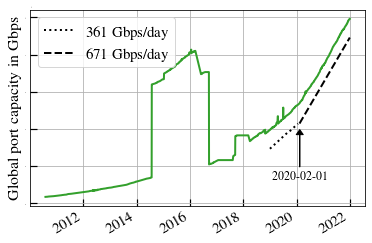

In [12]:
records = pd.read_csv("caida_pdbs/processed/records.csv", parse_dates=[0])
records.set_index("date", inplace=True)

from matplotlib import rc
import matplotlib.font_manager

plt.rc('lines', markersize=7)
plt.rc('lines', linewidth=2)

rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
rc('axes', **{"labelsize":16})
rc('axes', **{"titlesize":16})
rc('legend', **{"fontsize":15})
rc('xtick', **{"labelsize":15,"direction":"in","major.size":7,"major.width":1.6, "minor.size":4,"major.width":1.2})
rc('ytick', **{"labelsize":1,"direction":"in","major.size":7,"major.width":1.6, "minor.size":0,"major.width":1.2})

def myLinFunc(x, a, b):
    return a + x*b

def linfit(xdata, ydata):
    """
    Linear fit
    Return fitted ydata, [a,b], R2 score
    """
    popt, pcov = curve_fit(myLinFunc, xdata, ydata)
    
    ss_res = np.sum((ydata - myLinFunc(xdata, *popt))**2) #sum of square residuals
    ss_tot = np.sum((ydata - np.mean(ydata))**2) #total sum of square
    
    yfit = myLinFunc(xdata, *popt)
    r_squared = 1 - (ss_res/ss_tot)
    
    return yfit, popt, r_squared

inflexion = "2020-02-01"
inset_start = "2019-01-01"
inset_stop = "2021-12-31"

style = {"color": "#33a02c", "linewidth":2.0, "markersize":0.0, "zorder":2, "marker":"+", "mew":1.5, "label":"_"}

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)

(records["global_portcapa"]/1e3).plot(ax=ax, **style)

yfit1, popt1, r_squared1 = linfit(np.asarray([i for i in range(len(records.loc[inset_start:inflexion]))]), records.loc[inset_start:inflexion]["global_portcapa"].values/1e3)
yfit1 = {records.loc[inset_start:inflexion].index[i]: yfit1[i] for i in range(yfit1.size)}

yfit2, popt2, r_squared2 = linfit(np.asarray([i for i in range(len(records.loc[inflexion:inset_stop]))]), records.loc[inflexion:inset_stop]["global_portcapa"].values/1e3)
yfit2 = {records.loc[inflexion:inset_stop].index[i]: yfit2[i] for i in range(yfit2.size)}

print(popt1, popt2)

records["fit"] = records.index.map({**yfit1, **yfit2})
(records.loc[:inflexion]["fit"] - 1e5).plot(ax=ax, marker = "", 
           linewidth=2, zorder=12, linestyle="dotted", color="black", 
           label=r"%d Gbps/day"%(abs(popt1[1])))
(records.loc[inflexion:]["fit"] - 1e5).plot(ax=ax, marker = "", 
           linewidth=2, zorder=12,linestyle="dashed", color="black", 
           label=r"%d Gbps/day"%(abs(popt2[1])))

ax.annotate(inflexion, xycoords=ax.transAxes, xy=(0.805, 0.40), xytext=(0.805, 0.15),
            arrowprops=dict(facecolor='black', shrink=0.05, mutation_scale=0.5,
                           width = 0.1, headwidth=7, headlength=5),
           ha="center", va="center",fontsize=12)

ax.legend()
ax.ticklabel_format(axis="y", style="sci", scilimits=(-3,3))
# ax.grid(linestyle="dotted")
ax.grid()
ax.set_ylabel("Global port capacity in Gbps")
ax.set_xlabel("")
fig.savefig("portcapa_tot_v1.pdf", bbox_inches="tight")

with an inset to zoom on the inflexion

[3.93024869e+05 3.61119615e+02] 0.9675399505326089
[528687.1278018     671.89093605] 0.9984195776519149


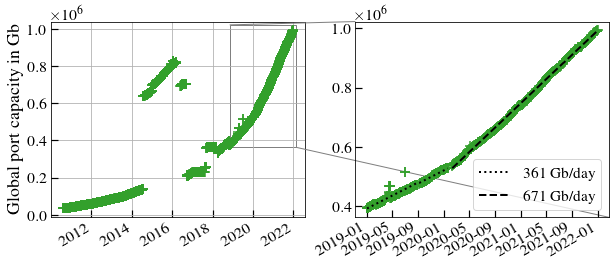

In [99]:
records = pd.read_csv("caida_pdbs/processed/records.csv", parse_dates=[0])
records.set_index("date", inplace=True)

from matplotlib import rc
import matplotlib.font_manager

from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

plt.rc('lines', markersize=7)
plt.rc('lines', linewidth=2)

rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
rc('axes', **{"labelsize":18})
rc('axes', **{"titlesize":18})
rc('legend', **{"fontsize":15.5})
rc('xtick', **{"labelsize":16,"direction":"in","major.size":7,"major.width":1.6, "minor.size":4,"major.width":1.2})
rc('ytick', **{"labelsize":16,"direction":"in","major.size":7,"major.width":1.6, "minor.size":0,"major.width":1.2})

def myLinFunc(x, a, b):
    return a + x*b

def linfit(xdata, ydata):
    """
    Linear fit
    Return fitted ydata, [a,b], R2 score
    """
    popt, pcov = curve_fit(myLinFunc, xdata, ydata)
    
    ss_res = np.sum((ydata - myLinFunc(xdata, *popt))**2) #sum of square residuals
    ss_tot = np.sum((ydata - np.mean(ydata))**2) #total sum of square
    
    yfit = myLinFunc(xdata, *popt)
    r_squared = 1 - (ss_res/ss_tot)
    
    return yfit, popt, r_squared

inflexion = "2020-02-01"
inset_start = "2019-01-01"
inset_stop = "2021-12-31"

style = {"color": "#33a02c", "linewidth":0, "markersize":10, "zorder":2, "marker":"+", "mew":1.5, "label":"_"}

fig, (ax, ax2) = plt.subplots(ncols=2, figsize=(10,4))

(records["global_portcapa"]/1e3).plot(ax=ax, **style)


(records["global_portcapa"]/1e3).loc[inset_start:inset_stop].plot(ax=ax2, **style)
# Mark the region corresponding to the inset axes on ax1 and draw lines
# in grey linking the two axes.

yfit1, popt1, r_squared1 = linfit(np.asarray([i for i in range(len(records.loc[inset_start:inflexion]))]), records.loc[inset_start:inflexion]["global_portcapa"].values/1e3)
yfit1 = {records.loc[inset_start:inflexion].index[i]: yfit1[i] for i in range(yfit1.size)}

yfit2, popt2, r_squared2 = linfit(np.asarray([i for i in range(len(records.loc[inflexion:inset_stop]))]), records.loc[inflexion:inset_stop]["global_portcapa"].values/1e3)
yfit2 = {records.loc[inflexion:inset_stop].index[i]: yfit2[i] for i in range(yfit2.size)}

print(popt1, r_squared1)
print(popt2, r_squared2)

records["fit"] = records.index.map({**yfit1, **yfit2})
records.loc[inset_start:inflexion]["fit"].plot(ax=ax2, marker = "", 
           linewidth=2, zorder=12, linestyle="dotted", color="black", 
           label=r"%d Gb/day"%(abs(popt1[1])))
records.loc[inflexion:inset_stop]["fit"].plot(ax=ax2, marker = "", 
           linewidth=2, zorder=12,linestyle="dashed", color="black", 
           label=r"%d Gb/day"%(abs(popt2[1])))


ax2.patch.set_alpha(0.5)

mark_inset(ax, ax2, loc1=2, loc2=4, fc="none", ec='0.5')


ax.ticklabel_format(axis="y", style="sci", scilimits=(-3,3))
# ax.grid(linestyle="dotted")
ax.grid()
ax.set_ylabel("Global port capacity in Gb")
ax.set_xlabel('')


ax2.legend(loc=4)
ax2.ticklabel_format(axis="y", style="sci", scilimits=(-3,3))
ax2.set_xlabel('')

fig.savefig("portcapa_tot_v2.pdf", bbox_inches="tight")